In [2]:
%matplotlib notebook
import notebook

import torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import utils
from utils import load_train, AE, ResBlock2D, View, Flatten, as_shape
from SSIM import SSIM # structural similarity loss...

import jnu as J

config = dict(
    device = "cuda:0",
    state_shape = (3,84,84),
    latent_shape = (256,),
    batch_size = 256,
    learning_rate = 0.0005,
    epochs = 10
)
config = SimpleNamespace(**config)


# load a dataset for testing
import os
import h5py
from tqdm.auto import tqdm
from pprint import pprint

def load(file, keys):
    with h5py.File(file, 'r') as f:
        for g in tqdm(f):
            yield tuple([f[g][k] for k in keys])
BUG_LABELS = ["TextureMissing", "ZFighting", "ZClipping", "CameraClipping", "BlackScreen", "TextureCorrupt", "ScreenTear", "GeometryCorruption", ]
WORLDOFBUGS_PATH = os.path.abspath("../worldofbugs/builds/World-v1/dataset/")
FILE_TEMPLATE = "dataset-{0}.hdf5"
FILES = [(bug, os.path.join(WORLDOFBUGS_PATH, FILE_TEMPLATE.format(i))) for i, bug in enumerate(BUG_LABELS, 1)]
pprint(FILES)


[('TextureMissing',
  '/home/ben/Documents/repos/WorldOfBugs/worldofbugs/builds/World-v1/dataset/dataset-1.hdf5'),
 ('ZFighting',
  '/home/ben/Documents/repos/WorldOfBugs/worldofbugs/builds/World-v1/dataset/dataset-2.hdf5'),
 ('ZClipping',
  '/home/ben/Documents/repos/WorldOfBugs/worldofbugs/builds/World-v1/dataset/dataset-3.hdf5'),
 ('CameraClipping',
  '/home/ben/Documents/repos/WorldOfBugs/worldofbugs/builds/World-v1/dataset/dataset-4.hdf5'),
 ('BlackScreen',
  '/home/ben/Documents/repos/WorldOfBugs/worldofbugs/builds/World-v1/dataset/dataset-5.hdf5'),
 ('TextureCorrupt',
  '/home/ben/Documents/repos/WorldOfBugs/worldofbugs/builds/World-v1/dataset/dataset-6.hdf5'),
 ('ScreenTear',
  '/home/ben/Documents/repos/WorldOfBugs/worldofbugs/builds/World-v1/dataset/dataset-7.hdf5'),
 ('GeometryCorruption',
  '/home/ben/Documents/repos/WorldOfBugs/worldofbugs/builds/World-v1/dataset/dataset-8.hdf5')]


In [3]:
model = AE(config.state_shape, config.latent_shape)
model.load_state_dict(torch.load("./AE-SSIM-256.pt"))
#criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion = SSIM(size_average=False)

TextureMissing


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4999), Output()), _d…

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


<IPython.core.display.Javascript object>


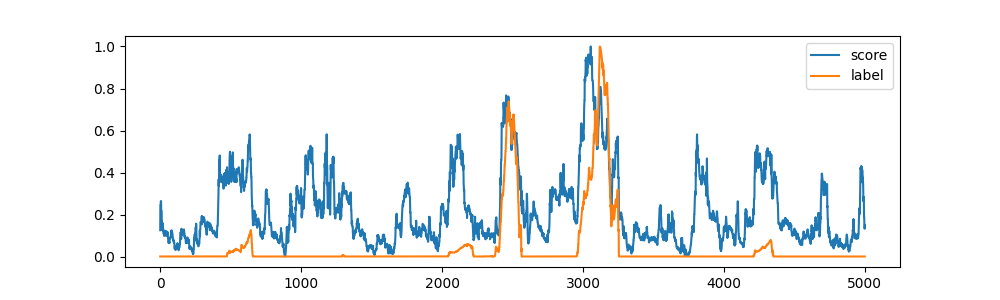


ZFighting


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4999), Output()), _d…

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


<IPython.core.display.Javascript object>


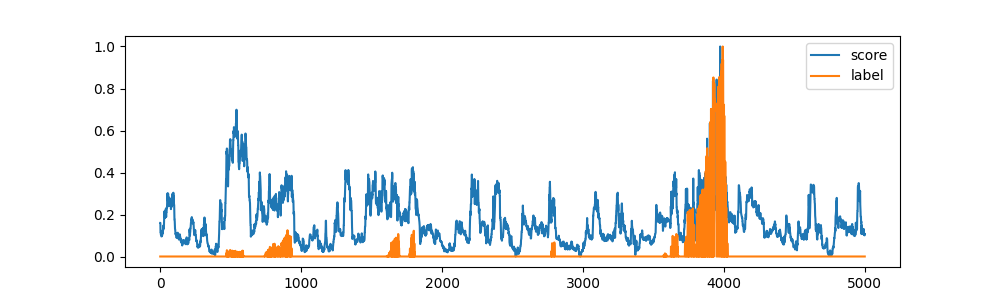


ZClipping


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4999), Output()), _d…

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


<IPython.core.display.Javascript object>


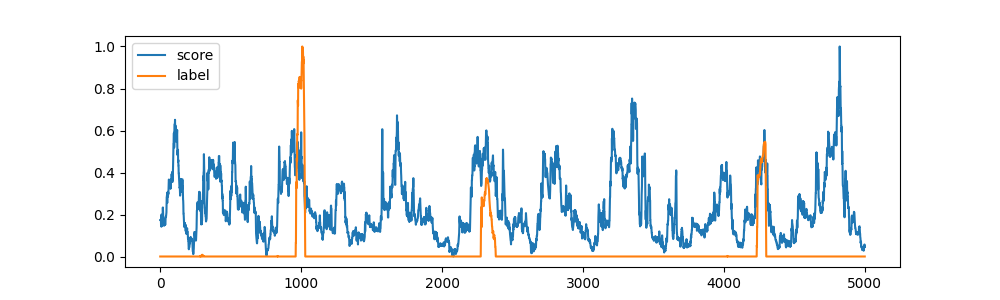


CameraClipping


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4999), Output()), _d…

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


<IPython.core.display.Javascript object>


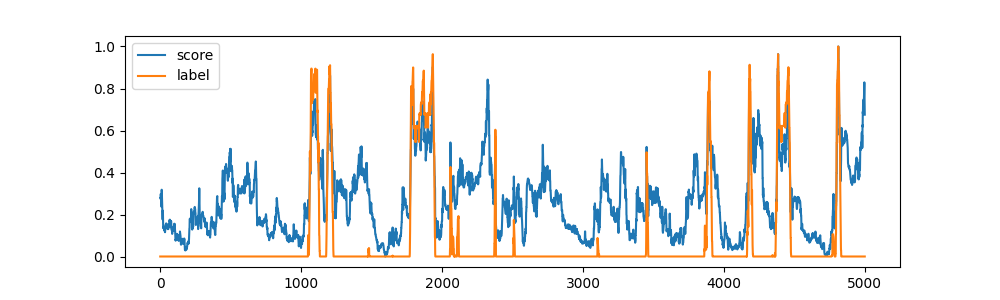


BlackScreen


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4999), Output()), _d…

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


<IPython.core.display.Javascript object>


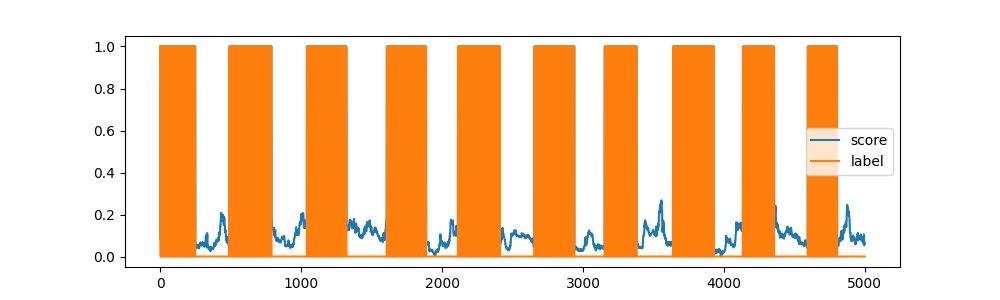


TextureCorrupt


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4999), Output()), _d…

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


<IPython.core.display.Javascript object>


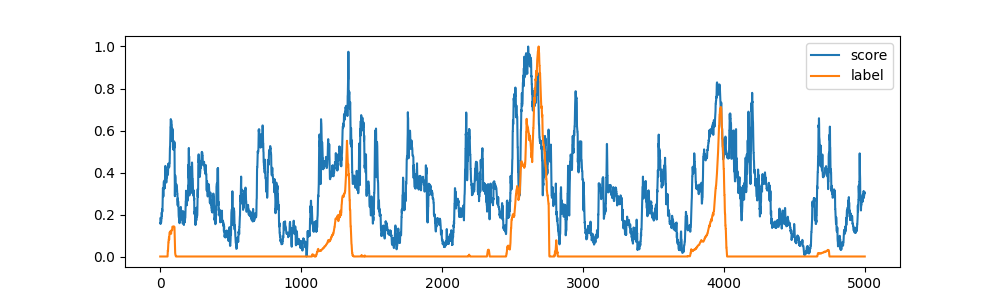


ScreenTear


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4999), Output()), _d…

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


<IPython.core.display.Javascript object>


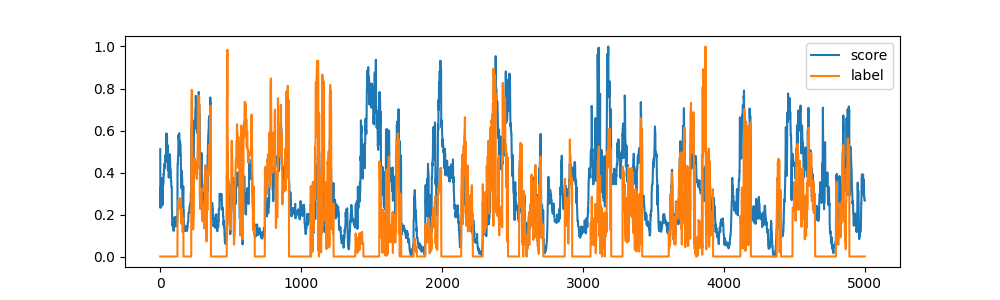


GeometryCorruption


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=4999), Output()), _d…

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


<IPython.core.display.Javascript object>


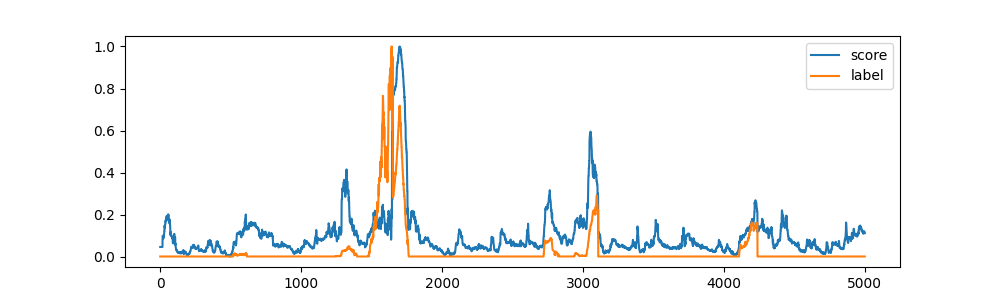

In [5]:
def model_forward(model, obs):
    with torch.no_grad():
        obs = torch.from_numpy(obs[...])
        loader = DataLoader(obs, batch_size=512)
        result = [model(x) for x in loader]
        return torch.clip(torch.cat(result),0,1).numpy()

def accuracy(label, score, thresholds=np.arange(1,20) * 0.05):
    print(thresholds)
    # convert labels 

select = [0, 1]
plot = True


for bug, file in FILES:
    print(bug)
    for i, (obs, label) in enumerate(load(file=file, keys=["observation", "bugmask"])):
        if not i in select:
            continue
        #obs, label = obs[:100], label[:100]
        obs, label = obs[...], label[...]
        pred = model_forward(model, obs)
        label = (label[...].sum(1, keepdims=True) > 0.)
        if plot:
            J.images(np.concatenate([obs, pred, label.repeat(3, axis=1)], axis=3), scale=3)
        
        score = criterion(torch.from_numpy(pred), torch.from_numpy(obs)).numpy()
        score = np.interp(score, (score.min(), score.max()), (0, 1))
        label = label.sum(-1).sum(-1).sum(-1)
        label = np.interp(label, (label.min(), label.max()), (0, 1))
        
        accuracy(label, score)
        
        if plot:
            fig = plt.figure(figsize=(10,3))
            plt.plot(np.arange(score.shape[0]), score, label="score")
            plt.plot(np.arange(label.shape[0]), label, label="label", alpha=0.5)
            plt.legend()
            
        
        break

In [ ]:
data = dict()
for (obs, label) in test_data:
    print(np.unique(label))

In [ ]:
model = AE(config.state_shape, config.latent_shape)
model.load_state_dict(torch.load("./AE-SSIM-256.pt"))
#criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion = SSIM(size_average=False)

In [ ]:
with torch.no_grad():
    n = 1024
    model = model.cpu()
    for obs, mask in test_data:
        obs, mask = obs[:n], mask[:n]
        obs = obs.cpu()
        pred = model(obs).cpu()
        score = criterion(pred, obs)
        print(score.shape)
        
        score = score.reshape(score.shape[0],-1).sum(-1).cpu().numpy()
        score = np.interp(score, (score.min(), score.max()), (0, +1))
        
        label = mask.reshape(mask.shape[0],-1).sum(-1).cpu().numpy()
        label = np.interp(label, (label.min(), label.max()), (0, +1))
        
        J.images(torch.cat([torch.clip(pred,0,1), obs.cpu(), mask], dim=3))
        fig = plt.figure(figsize=(10,5))
        plt.plot(np.arange(score.shape[0]), score, label="score")
        plt.plot(np.arange(score.shape[0]), label, label="label")
        plt.legend()